In [1]:
!pip install numpy pandas matplotlib seaborn scikit-learn lifelines watermark --quiet

<a id='Top'></a>

# Prepare clinical data <a class='tocSkip'></a>

Preprocess clinical data for all patients, collect relevant survival labels and define train/validation/test split using the unique patient ID codes.

In [1]:
%load_ext autoreload
%autoreload 2

%load_ext watermark

import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from lifelines import KaplanMeierFitter

In [2]:
DATA_LOCATION = '/mnt/data/d.kornilov/TCGA/processed_mtcp_intersection_all' #'/mnt/data/d.kornilov/TCGA/processed_mtcp/Clinical/'
MULTISURV_CLINICAL_DATA_LOCATION = '/mnt/dataA/TCGA/raw/clinical_data.tsv'
MTCP_CLINICAL_DATA_LOCATION = '../../mtcp/src/data/dataset_full_tcga_with_dna_balanced.csv'#'../../mtcp/src/data/dataset.csv'

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-and-explore-data" data-toc-modified-id="Load-and-explore-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load and explore data</a></span></li><li><span><a href="#Select-variables" data-toc-modified-id="Select-variables-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Select variables</a></span></li><li><span><a href="#Clean-up-inconsistencies" data-toc-modified-id="Clean-up-inconsistencies-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Clean up inconsistencies</a></span><ul class="toc-item"><li><span><a href="#Consolidate-race-and-ethnicity" data-toc-modified-id="Consolidate-race-and-ethnicity-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Consolidate <code>race</code> and <code>ethnicity</code></a></span></li><li><span><a href="#Missing-label-data" data-toc-modified-id="Missing-label-data-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Missing label data</a></span><ul class="toc-item"><li><span><a href="#vital_status" data-toc-modified-id="vital_status-3.2.1"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span><code>vital_status</code></a></span></li><li><span><a href="#Both-duration-values" data-toc-modified-id="Both-duration-values-3.2.2"><span class="toc-item-num">3.2.2&nbsp;&nbsp;</span>Both duration values</a></span></li><li><span><a href="#Required-duration-value" data-toc-modified-id="Required-duration-value-3.2.3"><span class="toc-item-num">3.2.3&nbsp;&nbsp;</span>Required duration value</a></span></li></ul></li><li><span><a href="#Not-missing-days_to_last_follow_up-when-vital_status-is-&quot;Dead&quot;" data-toc-modified-id="Not-missing-days_to_last_follow_up-when-vital_status-is-&quot;Dead&quot;-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Not missing <code>days_to_last_follow_up</code> when <code>vital_status</code> is "Dead"</a></span></li><li><span><a href="#Negative-durations" data-toc-modified-id="Negative-durations-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Negative durations</a></span></li></ul></li><li><span><a href="#Label-data" data-toc-modified-id="Label-data-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Label data</a></span></li><li><span><a href="#Train-val-test-split" data-toc-modified-id="Train-val-test-split-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Train-val-test split</a></span><ul class="toc-item"><li><span><a href="#Survival-curves" data-toc-modified-id="Survival-curves-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Survival curves</a></span></li></ul></li><li><span><a href="#Save-clinical-data-to-file" data-toc-modified-id="Save-clinical-data-to-file-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Save clinical data to file</a></span></li><li><span><a href="#Input-missing-values" data-toc-modified-id="Input-missing-values-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Input missing values</a></span></li><li><span><a href="#Scale-continuous-variables" data-toc-modified-id="Scale-continuous-variables-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Scale continuous variables</a></span></li><li><span><a href="#Encode-categorical-variables" data-toc-modified-id="Encode-categorical-variables-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Encode categorical variables</a></span></li><li><span><a href="#Save-patient-data-to-files" data-toc-modified-id="Save-patient-data-to-files-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Save patient data to files</a></span><ul class="toc-item"><li><span><a href="#Survival-labels" data-toc-modified-id="Survival-labels-10.1"><span class="toc-item-num">10.1&nbsp;&nbsp;</span>Survival labels</a></span></li><li><span><a href="#Clinical-data" data-toc-modified-id="Clinical-data-10.2"><span class="toc-item-num">10.2&nbsp;&nbsp;</span>Clinical data</a></span></li></ul></li></ul></div>

# Load and explore data

General exploration of data to remove features:
    * missing all data
    * with as many levels as there are patients

In [4]:
# clinical = pd.read_csv(MULTISURV_CLINICAL_DATA_LOCATION,
#                        sep='\t', na_values=['not reported', 'Not Reported'],
#                        low_memory=False)
clinical = pd.read_csv(MTCP_CLINICAL_DATA_LOCATION)

In [5]:
clinical.shape

(10082, 22)

In [6]:
print('~~ MISSING DATA ~~')
print()

n = clinical.shape[0]

for col in clinical.columns:
    if col == 'submitter_id':
        continue

    n_levels = len(clinical[col].value_counts())
    
    if n_levels == n:
        clinical = clinical.drop(columns=[col])
    else:
        n_missing = sum(clinical[col].isnull())
        if n_missing > 0:
            if n_missing == n:
                clinical = clinical.drop(columns=[col])
                print(f'{col}: {n} (100%)')
            else:
                print(f'{col}: {n_missing} ({round(n_missing / n * 100, 2)}%)')
        else:
            print(f'{col}: 0 (0%)')

~~ MISSING DATA ~~

tumor_stage: 3864 (38.33%)
age_at_diagnosis: 86 (0.85%)
prior_treatment: 4 (0.04%)
prior_malignancy: 1075 (10.66%)
synchronous_malignancy: 1777 (17.63%)
days_to_last_follow_up: 3265 (32.38%)
gender: 0 (0%)
race: 811 (8.04%)
vital_status: 0 (0%)
days_to_death: 6817 (67.62%)
treatments_pharmaceutical_treatment_or_therapy: 1146 (11.37%)
treatments_radiation_treatment_or_therapy: 1091 (10.82%)
project_id: 0 (0%)
time: 0 (0%)
event: 0 (0%)
RNA: 1098 (10.89%)
DNAm: 784 (7.78%)
WSI: 1517 (15.05%)
MRI: 9917 (98.36%)
splits: 0 (0%)
group: 0 (0%)


In [7]:
clinical.shape

(10082, 22)

# Select variables

Select a few variables to keep and drop the remaining ones.

In [8]:
clinical.columns

Index(['submitter_id', 'tumor_stage', 'age_at_diagnosis', 'prior_treatment',
       'prior_malignancy', 'synchronous_malignancy', 'days_to_last_follow_up',
       'gender', 'race', 'vital_status', 'days_to_death',
       'treatments_pharmaceutical_treatment_or_therapy',
       'treatments_radiation_treatment_or_therapy', 'project_id', 'time',
       'event', 'RNA', 'DNAm', 'WSI', 'MRI', 'splits', 'group'],
      dtype='object')

In [9]:
label_cols = ['submitter_id', 'days_to_last_follow_up', 'vital_status', 'days_to_death']

# keep_cols = ['tumor_stage', 'age_at_diagnosis', 'prior_treatment', 'prior_malignancy',
#              'synchronous_malignancy', 'gender', 'race', 'ethnicity', 'disease',
#              'treatments_pharmaceutical_treatment_or_therapy',
#              'treatments_radiation_treatment_or_therapy']

keep_cols = ['tumor_stage', 'age_at_diagnosis', 'prior_treatment', 'prior_malignancy',
             'synchronous_malignancy', 'gender', 'race',
             'treatments_pharmaceutical_treatment_or_therapy',
             'treatments_radiation_treatment_or_therapy', 
             'project_id', 'group', 'splits']

columns_to_drop = [col for col in clinical.columns if col not in label_cols + keep_cols]
clinical = clinical.drop(columns=columns_to_drop)

In [10]:
columns_to_drop

['time', 'event', 'RNA', 'DNAm', 'WSI', 'MRI']

In [11]:
print('~~ MISSING DATA ~~')
print()

n = clinical.shape[0]

for v in clinical.columns:
    n_missing = sum(clinical[v].isnull())
    if n_missing > 0:
        if n_missing == n:
            clinical = clinical.drop(columns=[v])
            print("column", v, "is fully missing")
        else:
            print(f'{v}: {n_missing} ({round(n_missing / n * 100, 2)}%)')

~~ MISSING DATA ~~

tumor_stage: 3864 (38.33%)
age_at_diagnosis: 86 (0.85%)
prior_treatment: 4 (0.04%)
prior_malignancy: 1075 (10.66%)
synchronous_malignancy: 1777 (17.63%)
days_to_last_follow_up: 3265 (32.38%)
race: 811 (8.04%)
days_to_death: 6817 (67.62%)
treatments_pharmaceutical_treatment_or_therapy: 1146 (11.37%)
treatments_radiation_treatment_or_therapy: 1091 (10.82%)


In [12]:
clinical.shape

(10082, 16)

In [13]:
clinical['gender'].value_counts()

gender
female    5225
male      4857
Name: count, dtype: int64

In [14]:
clinical['race'].value_counts()

race
white                                        7357
black or african american                     894
asian                                         630
hispanic or latino                            319
not hispanic or latino                         37
american indian or alaska native               23
native hawaiian or other pacific islander      11
Name: count, dtype: int64

In [15]:
# clinical['ethnicity'].value_counts()

In [16]:
clinical['prior_malignancy'].value_counts()

prior_malignancy
no     8171
yes     836
Name: count, dtype: int64

In [17]:
clinical['vital_status'].value_counts()

vital_status
Alive    6817
Dead     3265
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

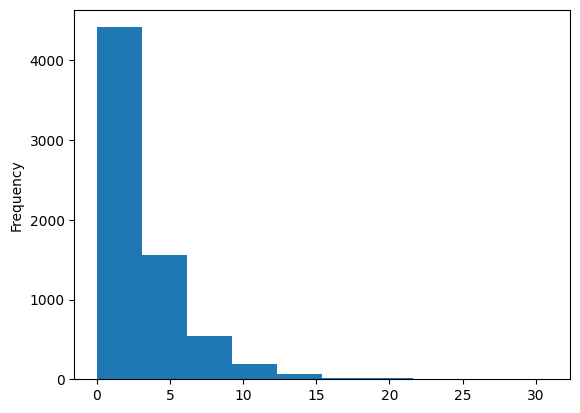

In [18]:
(clinical['days_to_last_follow_up']/365).plot(kind='hist')

<Axes: >

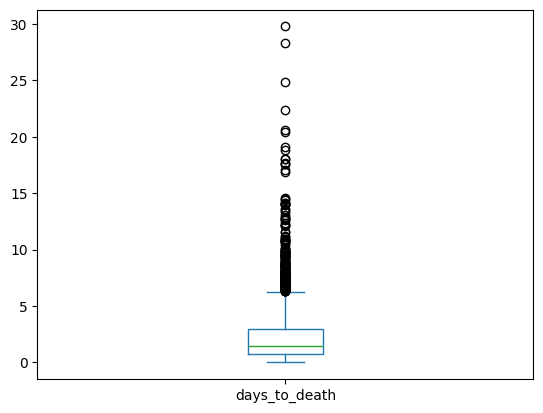

In [19]:
(clinical['days_to_death']/365).plot(kind='box')

<Axes: >

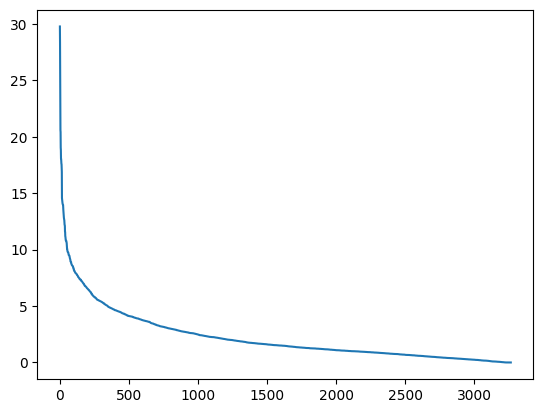

In [20]:
(clinical['days_to_death']/365).sort_values(ascending=False).plot(use_index=False)

<Axes: >

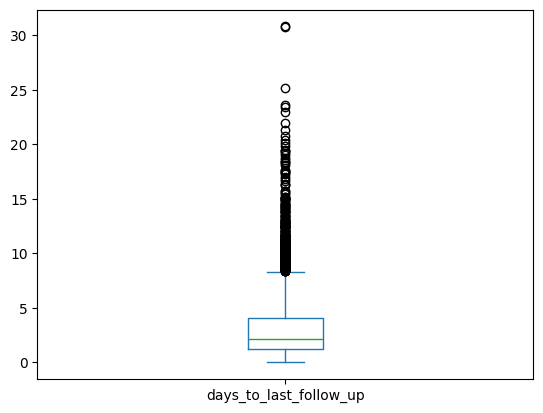

In [21]:
(clinical['days_to_last_follow_up']/365).plot(kind='box')

<Axes: >

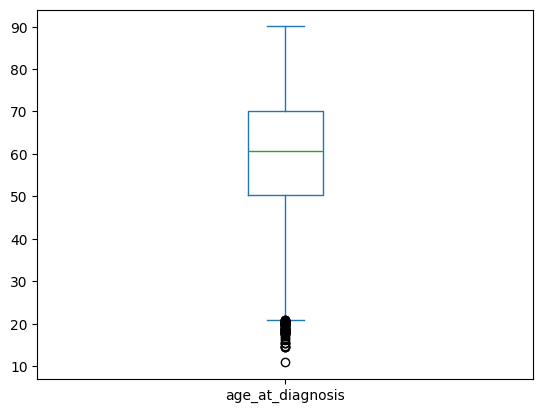

In [22]:
clinical['age_at_diagnosis'].apply(lambda x: x/365).plot(kind='box')

<Axes: >

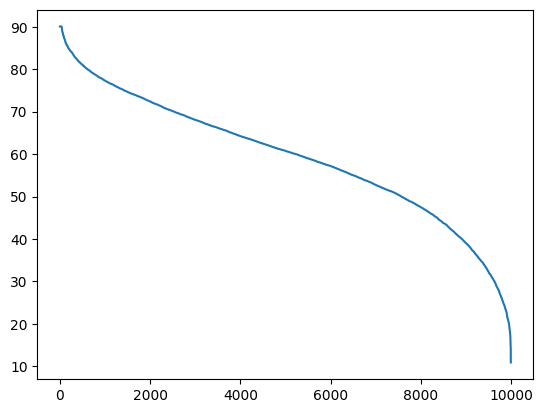

In [23]:
(clinical['age_at_diagnosis']/365).sort_values(ascending=False).plot(use_index=False)

In [24]:
clinical.describe()

,age_at_diagnosis,days_to_last_follow_up,days_to_death,splits
count,9996.000000,6817.000000,3265.000000,10082.000000
mean,21704.546919,1121.811061,832.091271,2.490974
std,5305.017305,1060.005413,932.886093,1.707615
min,3982.000000,0.000000,0.000000,0.000000
25%,18404.000000,438.000000,270.000000,1.000000
50%,22179.000000,797.000000,537.000000,2.000000
75%,25594.250000,1482.000000,1077.000000,4.000000
max,32872.000000,11252.000000,10870.000000,5.000000


In [25]:
clinical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10082 entries, 0 to 10081
Data columns (total 16 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   submitter_id                                    10082 non-null  object 
 1   tumor_stage                                     6218 non-null   object 
 2   age_at_diagnosis                                9996 non-null   float64
 3   prior_treatment                                 10078 non-null  object 
 4   prior_malignancy                                9007 non-null   object 
 5   synchronous_malignancy                          8305 non-null   object 
 6   days_to_last_follow_up                          6817 non-null   float64
 7   gender                                          10082 non-null  object 
 8   race                                            9271 non-null   object 
 9   vital_status                           

Rename `disease` column as `project_id` and set it as table index.

In [26]:
# clinical = clinical.rename(columns={'disease': 'project_id'})

In [27]:
clinical = clinical.set_index('submitter_id')

# Clean up inconsistencies

## Consolidate `race` and `ethnicity`

Whenever `race` value is "white" or missing replace it by `ethnicity` value (if present). Then drop ethnicity column.

In [28]:
clinical.loc[clinical['race'] == 'white', ].shape

(7357, 15)

## Missing label data

The data show some inconsistencies, such as patients missing `vital_status` information, showing negative `days_to_last_follow_up` values, or missing `days_to_death` values. This is addressed in a few discussions under GitHub issues. [In one of them](https://github.com/BioinformaticsFMRP/TCGAbiolinks/issues/324) someone asked and got the following explanation from the GDC:

> "I have talked to our Clinical Data Scientist and she said that these values can seem strange due to how TCGA and third parties handled patient data. For the negative follow up dates, this can be caused by the pathology report being made at a secondary institution that does the surgery, even though the patient was diagnosed at a local hospital. The larger institution/center eventually reports back the pathologic findings from the surgery, but they never receive follow-up information about the patient. Thus, the days to diagnosis would have been the date the pathology report was signed out, which is always day 0, but the last time the patient was seen relative to that date could have been days or weeks prior to that report being signed out. Basically, we are aware that these negative dates exist, and they are caused by pathology report dates taking priority as day 0. For the patients without days_to_death, this is the case that they knew the patient was deceased, but they were uncertain of the exact date. Thus, when filling out the clinical information they left this intentionally blank.."

Here, I will simply drop these patients from data. I did manually check on the online database the negative values, which matched my downloaded data.

### `vital_status`

In [29]:
print('~~ MISSING DATA ~~')
print()
skip = ['project_id', 'gender', 'race', 'ethnicity', 'prior_malignancy',
        'age_at_diagnosis', 'days_to_death', 'days_to_last_follow_up']

n = clinical.shape[0]

for v in clinical.columns:
    if v not in skip:
        n_missing = sum(clinical[v].isnull())
        print(f'{v}: {n_missing} ({round(n_missing / n * 100, 2)}%)')

~~ MISSING DATA ~~

tumor_stage: 3864 (38.33%)
prior_treatment: 4 (0.04%)
synchronous_malignancy: 1777 (17.63%)
vital_status: 0 (0.0%)
treatments_pharmaceutical_treatment_or_therapy: 1146 (11.37%)
treatments_radiation_treatment_or_therapy: 1091 (10.82%)
splits: 0 (0.0%)
group: 0 (0.0%)


In [30]:
# Drop patients missing "vital_status" information
subset = ~clinical.vital_status.isna()
clinical = clinical.loc[subset]

In [31]:
clinical.shape

(10082, 15)

### Both duration values

Patients missing both time to death and time to last follow up variables cannot be included in a survival study.

In [32]:
missing_duration_data = clinical[
    clinical['days_to_death'].isna() &
    clinical['days_to_last_follow_up'].isna()]

print('# patients missing both duration columns:', missing_duration_data.shape[0])

# patients missing both duration columns: 0


In [33]:
missing_duration_data.head()

,tumor_stage,age_at_diagnosis,prior_treatment,prior_malignancy,synchronous_malignancy,days_to_last_follow_up,gender,race,vital_status,days_to_death,treatments_pharmaceutical_treatment_or_therapy,treatments_radiation_treatment_or_therapy,project_id,splits,group
submitter_id,,,,,,,,,,,,,,,


In [34]:
# Remove missing data
subset = ~(clinical['days_to_death'].isna() &
           clinical['days_to_last_follow_up'].isna())
clinical = clinical.loc[subset]

In [35]:
clinical.shape

(10082, 15)

### Required duration value

Patients alive at the end of the study require time to last follow up information. Dead patients require time to death information.

In [36]:
print('# patients missing "days_to_last_follow_up" when "vital_status" is "Alive":',
      clinical[(clinical.vital_status == 'Alive') &
               clinical.days_to_last_follow_up.isna()].shape[0])

# patients missing "days_to_last_follow_up" when "vital_status" is "Alive": 0


In [37]:
print('# patients missing "days_to_death" when "vital_status" is "Dead":',
      clinical[(clinical.vital_status == 'Dead') &
               clinical.days_to_death.isna()].shape[0])

# patients missing "days_to_death" when "vital_status" is "Dead": 0


In [38]:
# Remove missing data
subset = ~((clinical.vital_status == 'Dead') &
           clinical.days_to_death.isna())
clinical = clinical.loc[subset]

In [39]:
clinical.shape

(10082, 15)

## Not missing `days_to_last_follow_up` when `vital_status` is "Dead"

In [40]:
print('"Days to death" variable missing for all patients still alive?',
      all(clinical[clinical.vital_status == 'Alive'].days_to_death.isna()))

"Days to death" variable missing for all patients still alive? True


In [41]:
print('"Days to last follow up" variable missing for all dead patients?',
      all(clinical[clinical.vital_status == 'Dead'].days_to_last_follow_up.isna()))

"Days to last follow up" variable missing for all dead patients? True


In [54]:
# Insert "NaN" in "days_to_last_follow_up" when "vital_status" is "Dead" 
subset = clinical.vital_status == 'Dead'
clinical.loc[subset, 'days_to_last_follow_up'] = None

In [55]:
print('"Days to last follow up" variable missing for all dead patients?',
      all(clinical[clinical.vital_status == 'Dead'].days_to_last_follow_up.isna()))

"Days to last follow up" variable missing for all dead patients? True


## Negative durations

In [56]:
clinical[clinical.days_to_last_follow_up < 0]

,tumor_stage,age_at_diagnosis,prior_treatment,prior_malignancy,synchronous_malignancy,days_to_last_follow_up,gender,race,vital_status,days_to_death,treatments_pharmaceutical_treatment_or_therapy,treatments_radiation_treatment_or_therapy,project_id,splits,group
submitter_id,,,,,,,,,,,,,,,


In [57]:
# Remove data
subset = ~((clinical.days_to_last_follow_up < 0) &
           (clinical.vital_status == 'Alive'))
clinical = clinical.loc[subset]

In [58]:
clinical.shape

(10082, 15)

# Label data

Collect duration label: `days_to_last_follow_up` and `days_to_death` for live and dead patients, respectively.

In [59]:
def get_duration(vital_status, days_to_death, days_to_last_follow_up):
    if vital_status == 'Dead':
        return days_to_death
    elif vital_status == 'Alive':
        return days_to_last_follow_up
    else:
        print('Found NaN in duration!')

def get_events(vital_status):
    if vital_status in ['1', 'Dead']:
        return 1
    elif vital_status in ['0', 'Alive']:
        return 0
    else:
        print('Found NaN in vital status!')

In [60]:
d = {'submitter_id': clinical.index,
     'time': clinical.apply(
         lambda x: get_duration(x['vital_status'], x['days_to_death'],
                                x['days_to_last_follow_up']), axis=1).values,
     'event': clinical.apply(
         lambda x: get_events(x['vital_status']), axis=1).values}

In [61]:
survival = pd.DataFrame.from_dict(d).astype(
    {'submitter_id': 'object', 'time': 'int64', 'event': 'int64'})

In [62]:
clinical = clinical.join(survival.set_index('submitter_id'))

In [63]:
clinical.head()

,tumor_stage,age_at_diagnosis,prior_treatment,prior_malignancy,synchronous_malignancy,days_to_last_follow_up,gender,race,vital_status,days_to_death,treatments_pharmaceutical_treatment_or_therapy,treatments_radiation_treatment_or_therapy,project_id,splits,group,time,event
submitter_id,,,,,,,,,,,,,,,,,
TCGA-3B-A9HJ,NaN,24962.0,No,yes,NaN,1104.0,male,white,Alive,NaN,no,yes,SARC,3.0,train,1104,0
TCGA-3B-A9HL,NaN,24628.0,No,no,No,NaN,male,white,Dead,599.0,yes,no,SARC,3.0,train,599,1
TCGA-3B-A9HO,NaN,27664.0,Yes,yes,NaN,959.0,male,white,Alive,NaN,no,no,SARC,1.0,train,959,0
TCGA-3B-A9HQ,NaN,24386.0,No,no,No,2085.0,female,white,Alive,NaN,no,no,SARC,5.0,test,2085,0
TCGA-3B-A9HR,NaN,14041.0,No,no,No,NaN,female,black or african american,Dead,2694.0,yes,yes,SARC,1.0,train,2694,1


# not done !!! Train-val-test split

Split by patient and stratify by `project_id`.

In [64]:
clinical['group'].value_counts()

group
train    8417
test     1665
Name: count, dtype: int64

In [65]:
clinical['splits'].value_counts()

splits
0.0    1694
1.0    1686
2.0    1683
3.0    1679
4.0    1675
5.0    1665
Name: count, dtype: int64

# Convert duration to years

In [66]:
# Convert duration to years
clinical['time'] = clinical['time'] / 365
clinical.head()

,tumor_stage,age_at_diagnosis,prior_treatment,prior_malignancy,synchronous_malignancy,days_to_last_follow_up,gender,race,vital_status,days_to_death,treatments_pharmaceutical_treatment_or_therapy,treatments_radiation_treatment_or_therapy,project_id,splits,group,time,event
submitter_id,,,,,,,,,,,,,,,,,
TCGA-3B-A9HJ,NaN,24962.0,No,yes,NaN,1104.0,male,white,Alive,NaN,no,yes,SARC,3.0,train,3.024658,0
TCGA-3B-A9HL,NaN,24628.0,No,no,No,NaN,male,white,Dead,599.0,yes,no,SARC,3.0,train,1.641096,1
TCGA-3B-A9HO,NaN,27664.0,Yes,yes,NaN,959.0,male,white,Alive,NaN,no,no,SARC,1.0,train,2.627397,0
TCGA-3B-A9HQ,NaN,24386.0,No,no,No,2085.0,female,white,Alive,NaN,no,no,SARC,5.0,test,5.712329,0
TCGA-3B-A9HR,NaN,14041.0,No,no,No,NaN,female,black or african american,Dead,2694.0,yes,yes,SARC,1.0,train,7.380822,1


## Survival curves

Plot Kaplan-Meier survival function.

<Axes: title={'center': 'Training data'}, xlabel='Time (years)'>

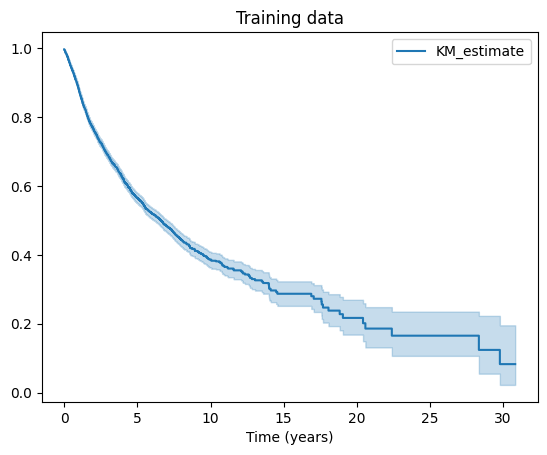

In [67]:
kmf = KaplanMeierFitter()
train = clinical[clinical['group'] == 'train']
kmf.fit(train['time'], event_observed=train['event'])
ax = kmf.plot(title='Training data')
ax.set_xlabel('Time (years)')
ax

<Axes: title={'center': 'Test data'}, xlabel='Time (years)'>

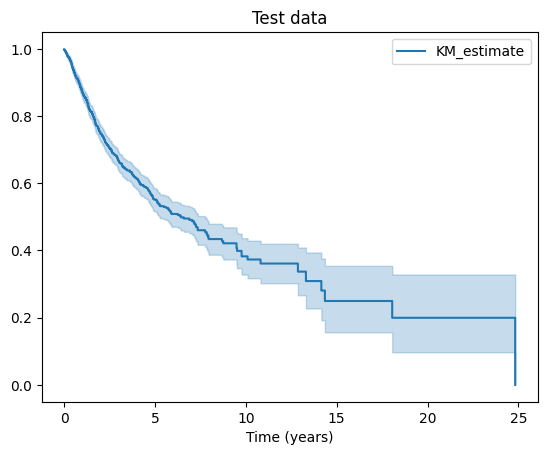

In [68]:
kmf = KaplanMeierFitter()
test = clinical[clinical['group'] == 'test']
kmf.fit(test['time'], event_observed=test['event'])
ax = kmf.plot(title='Test data')
ax.set_xlabel('Time (years)')
ax

# Save clinical data to file

To use in the visualization of the features learned by the model.

In [69]:
clinical.head()

,tumor_stage,age_at_diagnosis,prior_treatment,prior_malignancy,synchronous_malignancy,days_to_last_follow_up,gender,race,vital_status,days_to_death,treatments_pharmaceutical_treatment_or_therapy,treatments_radiation_treatment_or_therapy,project_id,splits,group,time,event
submitter_id,,,,,,,,,,,,,,,,,
TCGA-3B-A9HJ,NaN,24962.0,No,yes,NaN,1104.0,male,white,Alive,NaN,no,yes,SARC,3.0,train,3.024658,0
TCGA-3B-A9HL,NaN,24628.0,No,no,No,NaN,male,white,Dead,599.0,yes,no,SARC,3.0,train,1.641096,1
TCGA-3B-A9HO,NaN,27664.0,Yes,yes,NaN,959.0,male,white,Alive,NaN,no,no,SARC,1.0,train,2.627397,0
TCGA-3B-A9HQ,NaN,24386.0,No,no,No,2085.0,female,white,Alive,NaN,no,no,SARC,5.0,test,5.712329,0
TCGA-3B-A9HR,NaN,14041.0,No,no,No,NaN,female,black or african american,Dead,2694.0,yes,yes,SARC,1.0,train,7.380822,1


In [70]:
clinical.to_csv('clinical_data_mtcp_balanced.tsv', sep='\t')

# Load file with clinical data

In [3]:
clinical = pd.read_csv('clinical_data_mtcp_balanced.tsv', sep='\t').set_index("submitter_id", drop=True)
clinical.head()

,tumor_stage,age_at_diagnosis,prior_treatment,prior_malignancy,synchronous_malignancy,days_to_last_follow_up,gender,race,vital_status,days_to_death,treatments_pharmaceutical_treatment_or_therapy,treatments_radiation_treatment_or_therapy,project_id,splits,group,time,event
submitter_id,,,,,,,,,,,,,,,,,
TCGA-3B-A9HJ,NaN,24962.0,No,yes,NaN,1104.0,male,white,Alive,NaN,no,yes,SARC,3.0,train,3.024658,0
TCGA-3B-A9HL,NaN,24628.0,No,no,No,NaN,male,white,Dead,599.0,yes,no,SARC,3.0,train,1.641096,1
TCGA-3B-A9HO,NaN,27664.0,Yes,yes,NaN,959.0,male,white,Alive,NaN,no,no,SARC,1.0,train,2.627397,0
TCGA-3B-A9HQ,NaN,24386.0,No,no,No,2085.0,female,white,Alive,NaN,no,no,SARC,5.0,test,5.712329,0
TCGA-3B-A9HR,NaN,14041.0,No,no,No,NaN,female,black or african american,Dead,2694.0,yes,yes,SARC,1.0,train,7.380822,1


In [5]:
clinical.shape

(10082, 17)

In [4]:
new_splits = pd.read_csv("dataset_inetrsection_all.csv")[['submitter_id', 'splits', 'group']].set_index('submitter_id')
new_splits

,splits,group
submitter_id,,
TCGA-2F-A9KO,3.0,train
TCGA-2F-A9KP,2.0,train
TCGA-2F-A9KR,1.0,train
TCGA-2F-A9KW,5.0,test
TCGA-4Z-AA7M,5.0,test
...,...,...
TCGA-VQ-A8PC,3.0,train
TCGA-VQ-A8PM,5.0,test
TCGA-VQ-A8PU,0.0,train


In [6]:
other_columns = list(clinical.columns)
other_columns.remove('splits')
other_columns.remove('group')

new_clinical = pd.merge(
    how = 'inner',
    left = clinical[other_columns],
    right = new_splits,
    left_index=True,
    right_index=True
)

In [7]:
assert len(new_clinical) == len(new_splits), "ERROR: some patients are missing from the new splits"

In [8]:
clinical = new_clinical

In [9]:
for column, column_type in zip(clinical.columns, clinical.dtypes):
    temp_df = pd.DataFrame()

    if isinstance(clinical[column][0], np.float64):    
        temp_df['train']=(clinical[clinical['group'] == 'train'][column]/365).describe()
        temp_df['test']=(clinical[clinical['group'] == 'test'][column]/365).describe()
        
    else:
        temp_df['train']=clinical[clinical['group'] == 'train'][column].value_counts()
        temp_df['test']=clinical[clinical['group'] == 'test'][column].value_counts()

    print(column)
    display(temp_df)
    if len(temp_df) == 2:
        print(temp_df.iloc[0]/temp_df.iloc[1])

tumor_stage


/tmp/ipykernel_1414545/1038232923.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if isinstance(clinical[column][0], np.float64):


,train,test
tumor_stage,,
stage i,460,83.0
stage iib,396,84.0
stage iia,377,80.0
stage iiia,278,54.0
stage ii,269,51.0
stage iii,251,49.0
stage ib,242,36.0
stage ia,218,48.0
stage iv,208,37.0


age_at_diagnosis


/tmp/ipykernel_1414545/1038232923.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if isinstance(clinical[column][0], np.float64):


,train,test
count,3950.000000,780.000000
mean,61.134379,61.251131
std,13.576996,13.295355
min,16.060274,14.430137
25%,52.634932,53.344521
50%,62.106849,62.242466
75%,70.931507,71.145205
max,90.060274,90.060274


prior_treatment


/tmp/ipykernel_1414545/1038232923.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if isinstance(clinical[column][0], np.float64):


,train,test
prior_treatment,,
No,3952,781
Yes,42,6


train     94.095238
test     130.166667
dtype: float64
prior_malignancy


/tmp/ipykernel_1414545/1038232923.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if isinstance(clinical[column][0], np.float64):


,train,test
prior_malignancy,,
no,3544,696
yes,376,77


train    9.425532
test     9.038961
dtype: float64
synchronous_malignancy


/tmp/ipykernel_1414545/1038232923.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if isinstance(clinical[column][0], np.float64):


,train,test
synchronous_malignancy,,
No,3616,700
Yes,22,5


train    164.363636
test     140.000000
dtype: float64
days_to_last_follow_up


/tmp/ipykernel_1414545/1038232923.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if isinstance(clinical[column][0], np.float64):


,train,test
count,2770.000000,547.000000
mean,2.922235,2.860244
std,2.698988,2.512620
min,0.000000,0.000000
25%,1.200000,1.193151
50%,2.060274,2.030137
75%,3.871233,3.968493
max,23.575342,19.523288


gender


/tmp/ipykernel_1414545/1038232923.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if isinstance(clinical[column][0], np.float64):


,train,test
gender,,
female,2088,417
male,1908,371


train    1.094340
test     1.123989
dtype: float64
race


/tmp/ipykernel_1414545/1038232923.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if isinstance(clinical[column][0], np.float64):


,train,test
race,,
white,2845,568.0
black or african american,421,80.0
asian,318,63.0
hispanic or latino,127,22.0
american indian or alaska native,8,1.0
not hispanic or latino,7,1.0
native hawaiian or other pacific islander,7,NaN


vital_status


/tmp/ipykernel_1414545/1038232923.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if isinstance(clinical[column][0], np.float64):


,train,test
vital_status,,
Alive,2770,547
Dead,1226,241


train    2.25938
test     2.26971
dtype: float64
days_to_death


/tmp/ipykernel_1414545/1038232923.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if isinstance(clinical[column][0], np.float64):


,train,test
count,1226.000000,241.000000
mean,2.212657,2.009026
std,2.378660,2.241621
min,0.000000,0.005479
25%,0.756849,0.676712
50%,1.412329,1.328767
75%,2.809589,2.410959
max,20.424658,14.153425


treatments_pharmaceutical_treatment_or_therapy


/tmp/ipykernel_1414545/1038232923.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if isinstance(clinical[column][0], np.float64):


,train,test
treatments_pharmaceutical_treatment_or_therapy,,
no,1844,354
yes,1722,352


train    1.070848
test     1.005682
dtype: float64
treatments_radiation_treatment_or_therapy


/tmp/ipykernel_1414545/1038232923.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if isinstance(clinical[column][0], np.float64):


,train,test
treatments_radiation_treatment_or_therapy,,
no,2241,438
yes,1348,270


train    1.662463
test     1.622222
dtype: float64
project_id


/tmp/ipykernel_1414545/1038232923.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if isinstance(clinical[column][0], np.float64):


,train,test
project_id,,
BRCA,710,148
LGG,399,79
UCEC,360,71
LUSC,343,64
LUAD,337,68
HNSC,312,61
BLCA,283,54
STAD,268,53
KIRC,258,53


time


/tmp/ipykernel_1414545/1038232923.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if isinstance(clinical[column][0], np.float64):


,train,test
count,3996.000000,788.000000
mean,0.007410,0.007123
std,0.007192,0.006748
min,0.000000,0.000000
25%,0.002867,0.002835
50%,0.005022,0.004853
75%,0.009715,0.009257
max,0.064590,0.053488


event


/tmp/ipykernel_1414545/1038232923.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if isinstance(clinical[column][0], np.float64):


,train,test
event,,
0,2770,547
1,1226,241


train    2.25938
test     2.26971
dtype: float64
splits


/tmp/ipykernel_1414545/1038232923.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if isinstance(clinical[column][0], np.float64):


,train,test
count,3996.000000,7.880000e+02
mean,0.005476,1.369863e-02
std,0.003878,1.735825e-18
min,0.000000,1.369863e-02
25%,0.002740,1.369863e-02
50%,0.005479,1.369863e-02
75%,0.008219,1.369863e-02
max,0.010959,1.369863e-02


group


/tmp/ipykernel_1414545/1038232923.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if isinstance(clinical[column][0], np.float64):


,train,test
group,,
train,3996,NaN


## Select only target cancers

In [12]:
clinical["project_id"].value_counts()

project_id
BRCA    858
LGG     478
UCEC    431
LUSC    407
LUAD    405
HNSC    373
BLCA    337
STAD    321
KIRC    311
LIHC    301
KIRP    234
PAAD    151
GBM      90
SKCM     87
Name: count, dtype: int64

In [13]:
TARGET_PROJECTS = ['UCEC'] #['GBM', 'LGG']
clinical_selected = clinical[clinical['project_id'].isin(TARGET_PROJECTS)]

In [14]:
clinical_selected.shape

(431, 17)

# Input missing values

* Input missing continuous data with median value.
* Leave categorical features unchanged, to treat missing data as its own category.

In [15]:
print('~~ MISSING DATA ~~')
print()
skip = ['project_id', 'days_to_death', 'days_to_last_follow_up']

n = clinical_selected.shape[0]

for v in clinical_selected.columns:
    if v not in skip:
        n_missing = sum(clinical_selected[v].isnull())
        if n_missing > 0:
            print(f'{v}: {n_missing} ({round(n_missing / n * 100, 2)}%)')

~~ MISSING DATA ~~

tumor_stage: 431 (100.0%)
age_at_diagnosis: 3 (0.7%)
synchronous_malignancy: 36 (8.35%)
race: 22 (5.1%)
treatments_pharmaceutical_treatment_or_therapy: 11 (2.55%)
treatments_radiation_treatment_or_therapy: 12 (2.78%)


In [16]:
def input_missing_values(feature, df):
    train_subset = df.loc[df['group'] == 'train', feature]
    try:
        input_value = train_subset.median()
        print(f'Median "{feature}": {input_value}')
    except TypeError:
        input_value = train_subset.mode().iloc[0]
        print(f'Mode "{feature}": {input_value}')

    df[feature].fillna(input_value, inplace=True)
    
    return df

In [17]:
clinical_selected = input_missing_values(feature='age_at_diagnosis', df=clinical_selected)

Median "age_at_diagnosis": 23498.0


/tmp/ipykernel_1414545/3612106728.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[feature].fillna(input_value, inplace=True)
/tmp/ipykernel_1414545/3612106728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature].fillna(input_value, inplace=True)


In [18]:
print('~~ MISSING DATA ~~')
print()
n = clinical_selected.shape[0]

for v in clinical_selected.columns:
    n_missing = sum(clinical_selected[v].isnull())
    if n_missing > 0:
        print(f'{v}: {n_missing} ({round(n_missing / n * 100, 2)}%)')

~~ MISSING DATA ~~

tumor_stage: 431 (100.0%)
synchronous_malignancy: 36 (8.35%)
days_to_last_follow_up: 70 (16.24%)
race: 22 (5.1%)
days_to_death: 361 (83.76%)
treatments_pharmaceutical_treatment_or_therapy: 11 (2.55%)
treatments_radiation_treatment_or_therapy: 12 (2.78%)


# Scale continuous variables

In [19]:
id_groups = {
    'train': list(clinical_selected.loc[clinical_selected['group'] == 'train', ].index),
    # 'val': list(clinical_selected.loc[clinical_selected['group'] == 'val', ].index),
    'test': list(clinical_selected.loc[clinical_selected['group'] == 'test', ].index)}

In [20]:
clinical_selected.columns

Index(['tumor_stage', 'age_at_diagnosis', 'prior_treatment',
       'prior_malignancy', 'synchronous_malignancy', 'days_to_last_follow_up',
       'gender', 'race', 'vital_status', 'days_to_death',
       'treatments_pharmaceutical_treatment_or_therapy',
       'treatments_radiation_treatment_or_therapy', 'project_id', 'time',
       'event', 'splits', 'group'],
      dtype='object')

In [21]:
skip

['project_id', 'days_to_death', 'days_to_last_follow_up']

In [22]:
continuous = ['age_at_diagnosis']

In [23]:
def min_max_scale(data, features, groups):
    train = data.loc[data.index.isin(groups['train']), features]

    scaler = MinMaxScaler()
    columns = train.columns
    scaler = scaler.fit(train[columns])
    
    data.loc[data.index.isin(groups['train']), features] = scaler.transform(
        train)
    # data.loc[data.index.isin(groups['val']), features] = scaler.transform(
    #     data.loc[data.index.isin(groups['val']), features])
    data.loc[data.index.isin(groups['test']), features] = scaler.transform(
        data.loc[data.index.isin(groups['test']), features])
    
    return data

In [24]:
clinical_selected = min_max_scale(data=clinical_selected, features=continuous, groups=id_groups)

In [25]:
clinical_selected.age_at_diagnosis.describe()

count    431.000000
mean       0.543480
std        0.196018
min       -0.032973
25%        0.419794
50%        0.542782
75%        0.671616
max        1.000000
Name: age_at_diagnosis, dtype: float64

In [26]:
clinical_selected.head()

,tumor_stage,age_at_diagnosis,prior_treatment,prior_malignancy,synchronous_malignancy,days_to_last_follow_up,gender,race,vital_status,days_to_death,treatments_pharmaceutical_treatment_or_therapy,treatments_radiation_treatment_or_therapy,project_id,time,event,splits,group
submitter_id,,,,,,,,,,,,,,,,,
TCGA-2E-A9G8,NaN,0.547380,No,yes,NaN,1249.0,female,black or african american,Alive,NaN,yes,yes,UCEC,3.421918,0,4.0,train
TCGA-4E-A92E,NaN,0.367350,No,no,No,13.0,female,black or african american,Alive,NaN,no,no,UCEC,0.035616,0,0.0,train
TCGA-5B-A90C,NaN,0.646201,No,no,No,1202.0,female,black or african american,Alive,NaN,yes,yes,UCEC,3.293151,0,3.0,train
TCGA-5S-A9Q8,NaN,0.316814,No,no,No,313.0,female,black or african american,Alive,NaN,yes,yes,UCEC,0.857534,0,5.0,test
TCGA-A5-A0G1,NaN,0.595274,No,no,No,NaN,female,white,Dead,3251.0,no,yes,UCEC,8.906849,1,0.0,train


# Encode categorical variables

Encode labels (with a value between 0 and n_classes-1) to use with categorical embeddings.

In [27]:
# Drop unnecessary columns
clinical_selected = clinical_selected.drop(columns=['days_to_death', 'days_to_last_follow_up', 'vital_status'])

In [28]:
clinical_selected.columns

Index(['tumor_stage', 'age_at_diagnosis', 'prior_treatment',
       'prior_malignancy', 'synchronous_malignancy', 'gender', 'race',
       'treatments_pharmaceutical_treatment_or_therapy',
       'treatments_radiation_treatment_or_therapy', 'project_id', 'time',
       'event', 'splits', 'group'],
      dtype='object')

In [29]:
clinical_selected.count()

tumor_stage                                         0
age_at_diagnosis                                  431
prior_treatment                                   431
prior_malignancy                                  431
synchronous_malignancy                            395
gender                                            431
race                                              409
treatments_pharmaceutical_treatment_or_therapy    420
treatments_radiation_treatment_or_therapy         419
project_id                                        431
time                                              431
event                                             431
splits                                            431
group                                             431
dtype: int64

In [30]:
skip = ['time', 'event', 'group', 'splits']
skip

['time', 'event', 'group', 'splits']

In [31]:
continuous

['age_at_diagnosis']

In [32]:
len(clinical_selected.columns)

14

In [33]:
categorical = [col for col in clinical_selected.columns if col not in skip + continuous]

len(skip) + len(continuous) + len(categorical)

14

In [34]:
for feat in categorical:
    print(f'{feat}: {len(clinical_selected[feat].unique())}')

tumor_stage: 1
prior_treatment: 2
prior_malignancy: 2
synchronous_malignancy: 2
gender: 1
race: 8
treatments_pharmaceutical_treatment_or_therapy: 3
treatments_radiation_treatment_or_therapy: 3
project_id: 1


In [35]:
len(clinical_selected.columns)

14

In [36]:
# Reorder columns
categorical = ['project_id',  'gender', 'race', 'prior_treatment', 'prior_malignancy', 'synchronous_malignancy',
               'treatments_pharmaceutical_treatment_or_therapy',
               'treatments_radiation_treatment_or_therapy',
               'tumor_stage'
]   

clinical_selected = clinical_selected[categorical + continuous + skip]

In [37]:
len(clinical_selected.columns)

14

In [38]:
# Save a copy of the table to allow inclusion of unencoded "project_id" in the labels table
survival = clinical_selected.copy()

In [39]:
# split_groups = ['train', 'val', 'test']
split_groups = ['train', 'test']

label_encoders = {}
for feature in categorical:
    clinical_selected[feature] = clinical_selected[feature].astype(str)
    label_encoders[feature] = LabelEncoder()
    label_encoders[feature].fit(
        clinical_selected.loc[clinical_selected['group'] == 'train', feature])

for group in split_groups:
    for feature in categorical:
        clinical_selected.loc[
            clinical_selected['group'] == group, feature] = label_encoders[feature].transform(
            clinical_selected.loc[clinical_selected['group'] == group, feature])

The embedding dimensions (in a list of two-tuples) are calculated in the next cell: number of unique values paired with the embedding dimension for each categorical feature.

The embedding size is determined according to the rule-of-thumb from the Fast.ai course.

In [40]:
categorical_dims = [int(clinical_selected[col].nunique()) for col in categorical]
embedding_dims = [(x, min(50, (x + 1) // 2)) for x in categorical_dims]

embedding_dims

print('Feature                                            Levels   Embedding dims')
print('-------                                            ------   --------------')
for i, feat in enumerate(categorical):
    print(feat, ' ' * (50 - len(feat)), embedding_dims[i][0],
          ' ' * (7 - len(str(embedding_dims[i][0]))), embedding_dims[i][1])

Feature                                            Levels   Embedding dims
-------                                            ------   --------------
project_id                                          1        1
gender                                              1        1
race                                                8        4
prior_treatment                                     2        1
prior_malignancy                                    2        1
synchronous_malignancy                              2        1
treatments_pharmaceutical_treatment_or_therapy      3        2
treatments_radiation_treatment_or_therapy           3        2
tumor_stage                                         1        1


In [41]:
embedding_dims

[(1, 1), (1, 1), (8, 4), (2, 1), (2, 1), (2, 1), (3, 2), (3, 2), (1, 1)]

In [42]:
clinical_selected.to_csv("clinical_data_mtcp_intersection_all_preprocessed_{}.tsv".format(",".join(TARGET_PROJECTS)), sep="\t")

# Save patient data to files

## Survival labels

In [43]:
survival['submitter_id'] = survival.index
survival = survival.reset_index(drop=True)

# label_columns = ['submitter_id', 'project_id', 'time', 'event', 'group']
label_columns = ['submitter_id', 'project_id', 'time', 'event', 'group', 'splits']
survival = survival.loc[:, label_columns]

In [44]:
survival.head()

,submitter_id,project_id,time,event,group,splits
0,TCGA-2E-A9G8,UCEC,3.421918,0,train,4.0
1,TCGA-4E-A92E,UCEC,0.035616,0,train,0.0
2,TCGA-5B-A90C,UCEC,3.293151,0,train,3.0
3,TCGA-5S-A9Q8,UCEC,0.857534,0,test,5.0
4,TCGA-A5-A0G1,UCEC,8.906849,1,train,0.0


In [45]:
survival['group'].value_counts()

group
train    360
test      71
Name: count, dtype: int64

In [46]:
survival.to_csv('labels_mtcp_intersection_all_{}.tsv'.format(",".join(TARGET_PROJECTS)), sep='\t', index=False)

## Clinical data

Save preprocessed clinical data as individual patient files (to use with PyTorch dataset).

In [47]:
skip

['time', 'event', 'group', 'splits']

In [48]:
clinical_selected = clinical_selected[categorical + continuous]

In [49]:
clinical_selected.head()

,project_id,gender,race,prior_treatment,prior_malignancy,synchronous_malignancy,treatments_pharmaceutical_treatment_or_therapy,treatments_radiation_treatment_or_therapy,tumor_stage,age_at_diagnosis
submitter_id,,,,,,,,,,
TCGA-2E-A9G8,0,0,2,0,1,1,2,2,0,0.547380
TCGA-4E-A92E,0,0,2,0,0,0,1,1,0,0.367350
TCGA-5B-A90C,0,0,2,0,0,0,2,2,0,0.646201
TCGA-5S-A9Q8,0,0,2,0,0,0,2,2,0,0.316814
TCGA-A5-A0G1,0,0,7,0,0,0,1,2,0,0.595274


In [50]:
def table_to_patient_files(table, dir_path, round_digits=4):
    n = len(table)
    
    i = 0

    for index, row in table.iterrows():
        print('\r' + f'Save data to files: {str(i + 1)}/{n}', end='')
        i+= 1

        target_file = os.path.join(dir_path, str(index) + '.tsv')
        
        with open(target_file, 'w') as f:
            if round_digits is not None:
                f.write('\n'.join(str(round(value, round_digits)) for value in row.values))
            else:
                f.write('\n'.join(str(value) for value in row.values))

    print()
    print()

In [51]:
%%time
target_path = os.path.join(DATA_LOCATION, "_".join(TARGET_PROJECTS), "Clinical")
if not os.path.exists(target_path):
    os.makedirs(target_path)
print(target_path)
table_to_patient_files(clinical_selected, dir_path=target_path, round_digits=None)

/mnt/data/d.kornilov/TCGA/processed_mtcp_intersection_all/UCEC/Clinical
Save data to files: 431/431

CPU times: user 30.1 ms, sys: 15.2 ms, total: 45.3 ms
Wall time: 70.5 ms


# Watermark <a class='tocSkip'></a>

In [52]:
%watermark --iversions
%watermark -v
print()
%watermark -u -n

numpy    : 1.26.4
pandas   : 2.3.2
lifelines: 0.30.0
sklearn  : 1.7.1

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 8.37.0


Last updated: Thu Sep 18 2025



[Top of the page](#Top)